In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Libries loading

In [201]:
import pandas as pd
import numpy as np

from pandas import DataFrame
from pandas import concat
from math import sqrt
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn import  svm

from sklearn.metrics import mean_absolute_error,mean_squared_error


### Clean Raw data

In [202]:
def CleanRawData(file_path):

  # Loading data as String
  with  open(file_path) as f: 
    txt_train = f.read()
    f.close()

  # Delete words of 'ip','timestamp','raw_messages','status_scores' from the Raw Data.
  txt_train = txt_train.replace('ip:','')
  txt_train = txt_train.replace('timestamp:','')
  txt_train = txt_train.replace('raw_messages:','')
  txt_train = txt_train.replace('status_score:','')

  # Write the modified string to a txt file
  with open(file_path,'w') as f:    
    f.write(txt_train)

  # Read the txt file into the csv required by machine learning to facilitate our subsequent processing.
  df = pd.read_csv(file_path,
                         delimiter=",",header= None,
                         names=('ip','timestamp','raw_messages','status_score'))
  
  return df

In [203]:
df =CleanRawData('/content/drive/My Drive/exercise/train.txt')
df_new = df.loc[:,['timestamp','status_score']]

## Missing value


In [204]:
def MissingValue(object):
  # Data visualization.
  # View missing values, and the distribution of status_score.
  missing_values = go.Scatter(x=object.index, y=object['status_score'])
  return py.iplot([missing_values]), print(object.isnull().sum())

MissingValue(df_new)

timestamp        0
status_score    72
dtype: int64


(None, None)

In [205]:
def fillVaules(object):
  # Fill in missing values by linear interpolation. 
  # The reason for using linear interpolation will be explained in the report
  object['status_score'] = object['status_score'].interpolate(method = 'linear')
fillVaules(df_new)
MissingValue(df_new)

timestamp       0
status_score    0
dtype: int64


(None, None)

## Unix time conversion

In [206]:
# Unix-time to 
def swtichUnixTime(object):
  # Convert the timestamp recorded by unixtime into the form of YYYY-MM-DD hh:mm:ss.
  object.timestamp = pd.to_datetime(object.timestamp, unit='s')

swtichUnixTime(df_new)

# Machine Learning model

##Feature engineering

### Train&Test dataset

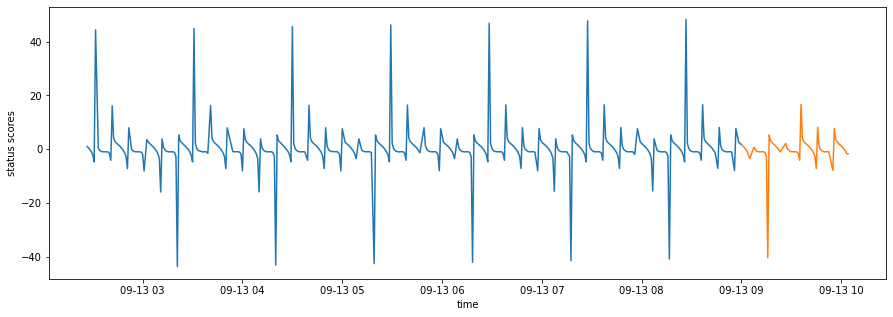

In [207]:
def split_data(df_new, split_date):
  # Set timestamp to DatetimeIndex for subsequent feature engineering.
  df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])
  df_new.set_index("timestamp", inplace=True)
  # Separate training set and test set.
  return df_new[df_new.index <= split_date].copy(), df_new[df_new.index > split_date].copy()

#Through the above status_score scatter plot over time. 
#Cut the training set and test set from 2021-09-13 9:00:00.
#Train data size is 473, Test data size is 77
train, test = split_data(df_new, '2021-09-13 9:00:00')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('status scores')
plt.plot(train.index,train)
plt.plot(test.index,test)

In [208]:
def create_features(object):
    # Creates time series features from datetime index
    # The selection of feature engineering will be explained in the report.
    object['date'] = object.index
    object['second'] = object['date'].dt.second
    object['minute'] = object['date'].dt.minute
    object['hour'] = object['date'].dt.hour
    x = object[['second','minute','hour']]
    return x
    
# Create training set and test set
x_train,y_train = create_features(train),train['status_score'].values
x_test,y_test = create_features(test),test['status_score'].values

In [209]:
def Evaluation(model):
  # Define evaluation function. RMSE,MAE
  Y_pred_model = model.predict(x_test)
  model_RMSE = mean_squared_error(y_test,Y_pred_model,squared = False)
  model_MAE = mean_absolute_error(y_test,Y_pred_model)
  print("RMSE    : ",model_RMSE)
  print('MAE     :',model_MAE)

## XGBoost

[23:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
*************************************************************************
RMSE    :  8.844851357397447
MAE     : 3.893387419010759
*************************************************************************


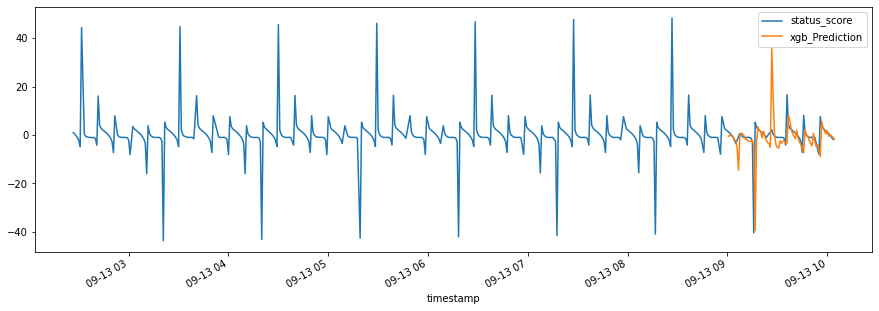

In [210]:
# Define XGBoost model
def fit_XGboost(x,y):
    model = xgb.XGBRegressor(n_estimators=1000)
    model.fit(x,y,
              eval_set=[(x, y), (x_test, y_test)],
       verbose=False)
    return model 

# Define prediction of XGBoost
def predict_XGBoost():
  # Store the test results in a DataFrame.
  test['xgb_Prediction'] = model_xgb.predict(x_test)
  data_all = pd.concat([test, train])
  # Plot the test results on the data set.
  Check_XGB= data_all[['status_score','xgb_Prediction']].plot(figsize=(15, 5))
  return Check_XGB

model_xgb = fit_XGboost(x_train,y_train)
print('*************************************************************************')
Evaluation(model_xgb)
print('*************************************************************************')
predict_XGBoost()

## LGBoost

*************************************************************************
RMSE    :  8.119198597294831
MAE     : 4.010927054138147
*************************************************************************


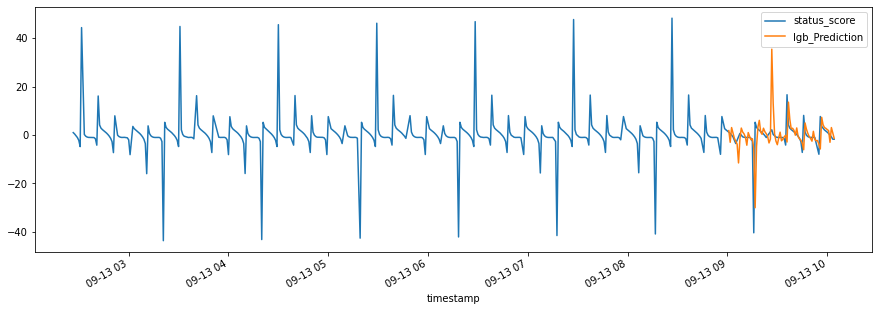

In [211]:
# Define LGBoost model
def fit_LGBoost(x,y):
    model = LGBMRegressor(n_estimators=1000)
    model.fit(x,y,
              eval_set=[(x, y), (x_test, y_test)],
       verbose=False)
    return model 

# Define prediction of LGBoost
def predict_LGBoost():
  # Store the test results in a DataFrame.
  test['lgb_Prediction'] = model_lgb.predict(x_test)
  data_all = pd.concat([test, train])
  # Plot the test results on the data set.
  Check_LGB= data_all[['status_score','lgb_Prediction']].plot(figsize=(15, 5))
  return Check_LGB


model_lgb = fit_LGBoost(x_train,y_train)
print('*************************************************************************')
Evaluation(model_lgb)
print('*************************************************************************')
predict_LGBoost()

##SVR

In [212]:
# First, let's choose which kernel is the best for our data
for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(x_train, y_train)
    confidence = clf.score(x_train, y_train)
    print(k,confidence)

linear -0.013649415272608323
poly -0.007315898821822042
rbf -0.0009495082249122433
sigmoid -5.300561591987186


*************************************************************************
RMSE    :  5.465703369417027
MAE     : 2.179766067188287
*************************************************************************


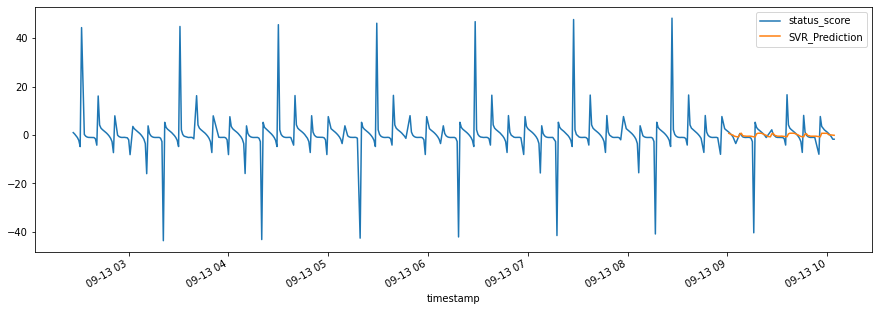

In [213]:
# Define Support Vector Regression model
def fit_svr(x,y):
    model = svm.SVR(kernel='rbf', C=1, gamma= 0.5)
    model.fit(x,y,)
    return model 

def predict_SVR():
  # Store the test results in a DataFrame.
  test['SVR_Prediction'] = model_svr.predict(x_test)
  data_all = pd.concat([test, train])
  # Plot the test results on the data set.
  Check_Svr= data_all[['status_score','SVR_Prediction']].plot(figsize=(15, 5))
  return Check_Svr


model_svr = fit_svr(x_train,y_train)
print('*************************************************************************')
Evaluation(model_svr)
print('*************************************************************************')
predict_SVR()

## Random Forest

*************************************************************************
RMSE    :  7.6283765832840285
MAE     : 3.4870916827878307
*************************************************************************


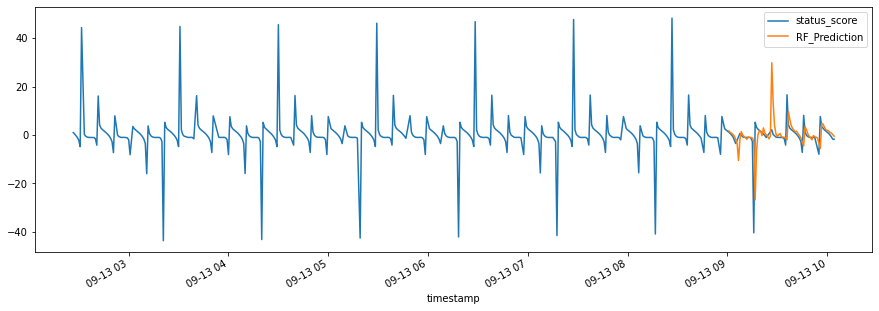

In [214]:
#Define Random Forest Regressor
def fit_RandomForest(x,y):
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(x,y)
    return model 

def predict_RandomForest():
  # Store the test results in a DataFrame.
  test['RF_Prediction'] = model_RF.predict(x_test)
  data_all = pd.concat([test, train])
  # Plot the test results on the data set.
  Check_LGB= data_all[['status_score','RF_Prediction']].plot(figsize=(15, 5))
  return Check_LGB

model_RF = fit_RandomForest(x_train,y_train)
print('*************************************************************************')
Evaluation(model_RF)
print('*************************************************************************')
predict_RandomForest()

In [215]:
# Put the prediction results of the 4 models into the same data set.
def data_all():
    test['lgb_Prediction'] = model_lgb.predict(x_test)
    data_all = pd.concat([test, train])
    test['xgb_Prediction'] = model_xgb.predict(x_test)
    data_all = pd.concat([test, train])
    test['SVR_Prediction'] = model_svr.predict(x_test)
    data_all = pd.concat([test, train])
    test['RF_Prediction'] = model_RF.predict(x_test)
    data_all = pd.concat([test, train])
    return data_all
data_all = data_all()

# Prediction on test.txt

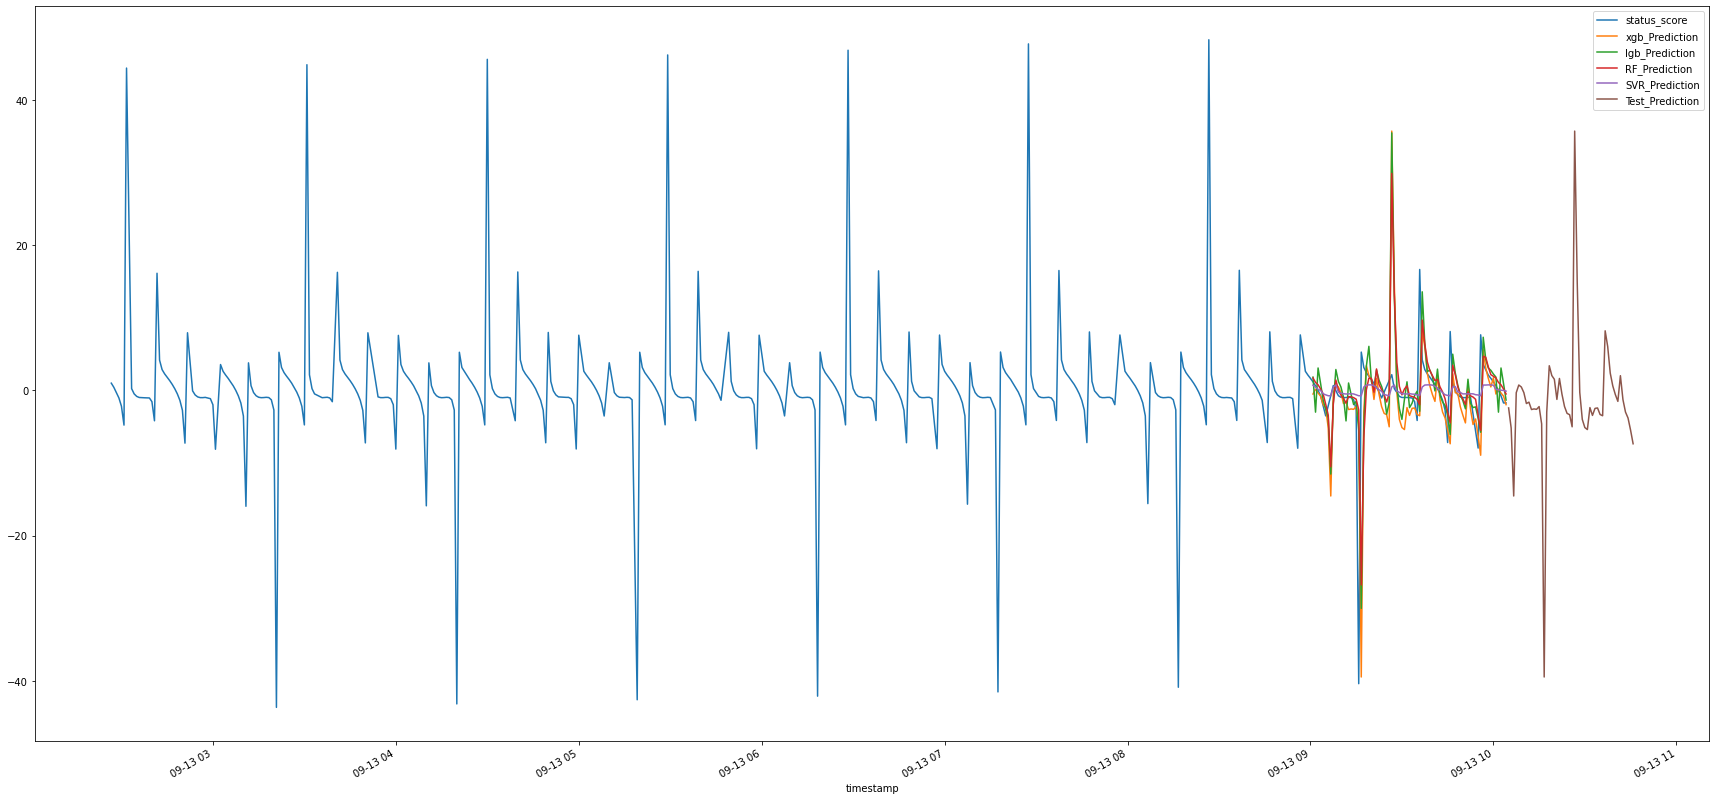

In [216]:
# Define function of Clean Test.txt
def CleanTestData(file_path):
    with open(file_path) as f:
      txt_test = f.read()
      f.close()

    # Do the same data processing on the test.txt.
    txt_test = txt_test.replace('timestamp:','')

    with open(file_path,'w') as f:    
      f.write(txt_test)
    
    df_pred = pd.read_csv(file_path,
                          delimiter=",",header= None)
    
    df_pred.columns = ['timestamp']
    return df_pred

def convert_test_index_timestmp():
  # Do the same data processing on the test.txt.
  df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'])
  df_pred.set_index("timestamp", inplace=True)

def predict_test_data():
  # Here XGBoost is used to predict the test.txt, 
  # and the reason for using XGBoost will be explained in the report.
  x_pred['Test_Prediction'] = model_xgb.predict(x_pred)
  PredWithall = pd.concat([data_all,x_pred])
  Check_all= PredWithall[['status_score','xgb_Prediction','lgb_Prediction','RF_Prediction','SVR_Prediction','Test_Prediction']].plot(figsize=(30, 15))
  return Check_all


df_pred = CleanTestData('/content/drive/My Drive/exercise/test.txt')
# convert unix-time 
swtichUnixTime(df_pred)
convert_test_index_timestmp()
# Feature engineering of the prediction set.
x_pred = create_features(df_pred)
predict_test_data()

In [217]:
x_pred = x_pred.drop(labels=['second',"hour",'minute'],axis=1)
x_pred

,Test_Prediction
timestamp,
2021-09-13 10:05:00,-2.410562
2021-09-13 10:05:50,-5.177670
2021-09-13 10:06:40,-14.545791
2021-09-13 10:07:30,-0.317132
2021-09-13 10:08:20,0.744526
2021-09-13 10:09:10,0.471168
2021-09-13 10:10:00,-0.305003
2021-09-13 10:10:50,-1.807613
2021-09-13 10:11:40,-1.616170


## Store predicted status_score into the test dataset

In [218]:
np.savetxt('/content/drive/My Drive/exercise/predict.txt', x_pred.values, )

In [219]:
# Write the predicted status_score of test.txt to the file.
file1 = open('/content/drive/My Drive/exercise/test.txt',"r")
file2 = open('/content/drive/My Drive/exercise/predict.txt',"r")
 
file1_lists =file1.readlines()
file2_lists =file2.readlines()
 
file3_list = []
file4_list = []

for i in file1_lists:
  temp_list = i.split()
  file3_list.append(str(temp_list[0]))

 
for i in file2_lists:
  temp_list = i.split()
  file4_list.append(str(temp_list[0]))

main_file = []
for i in range(len(file3_list)):
  s=""
  s = ":".join([file3_list[i],file4_list[i]])
  s+="\n"
  main_file.append(s)


In [220]:
file = open('/content/drive/My Drive/exercise/Three.txt','w')
file.writelines(main_file)
file.close()

# Walk-forward validation for XGBoost

In [221]:
"""
# 1. Convert the time series data set into a supervised learning data set.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n = 1 if type(data) is list else data.shape[1]
	df_WF = DataFrame(data)
	m= list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		m.append(df_WF.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		m.append(df_WF.shift(-i))
	# Merge all
	All = concat(m, axis=1)
	# Fill the NaN values using linear interpolation.
	if fillVaules:
		All.interpolate(method = 'linear',inplace=True)
	return All.values
 
# 2. Split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# 3. fit an xgboost model and make a one step prediction
def xgboost_forecast(train, test_X):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	train_X, train_y = train[:, :-1], train[:, -1]
	# fit XGB regressor model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(train_X, train_y)
	# make a one-step prediction
	yhat = model.predict(np.asarray([test_X]))
	return yhat[0]
 
# 4. walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		test_X, test_y = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, test_X)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('expected=%.1f, predicted=%.1f' % (test_y, yhat))
	# Define prediction error using MAE
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# Define target values
values = df_new.values

# Convert the time series data into supervised learning
data = series_to_supervised(values, n_in=50)

# Evaluation 
# Because the test machine has 50 time points, 
# we verify 50 points here to make it more intuitive.
mae, y, yhat = walk_forward_validation(data, 50)
print('MAE: %.3f' % mae)

# plot Predict data & Actual data
plt.plot(y, label='Actual data')
plt.plot(yhat, label='Predict data')
plt.legend()
plt.show()
"""

"\n# 1. Convert the time series data set into a supervised learning data set.\ndef series_to_supervised(data, n_in=1, n_out=1, dropnan=True):\n\tn = 1 if type(data) is list else data.shape[1]\n\tdf_WF = DataFrame(data)\n\tm= list()\n\t# input sequence (t-n, ... t-1)\n\tfor i in range(n_in, 0, -1):\n\t\tm.append(df_WF.shift(i))\n\t# forecast sequence (t, t+1, ... t+n)\n\tfor i in range(0, n_out):\n\t\tm.append(df_WF.shift(-i))\n\t# Merge all\n\tAll = concat(m, axis=1)\n\t# Fill the NaN values using linear interpolation.\n\tif fillVaules:\n\t\tAll.interpolate(method = 'linear',inplace=True)\n\treturn All.values\n \n# 2. Split a univariate dataset into train/test sets\ndef train_test_split(data, n_test):\n\treturn data[:-n_test, :], data[-n_test:, :]\n \n# 3. fit an xgboost model and make a one step prediction\ndef xgboost_forecast(train, test_X):\n\t# transform list into array\n\ttrain = np.asarray(train)\n\t# split into input and output columns\n\ttrain_X, train_y = train[:, :-1], train